In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad

In [ ]:
# Load in the raw data, which is a single cell RNA-seq sample of 48 hours post fertilization Heliocidaris erythrogramma larvae
# This takes in the gene expression counts data that is outputted from the 10X single cell sequencing process, which includes
# a tsv file of barcodes, a tsv file of gene names, and a matrix file of counts data.
# We retrieved this data from the NCBI Gene Expression Omnibus, accession GSE277518.

# After running the import function, an anndata/scanpy object is returned, which stores the gene counts data for each cell, 
# as well as other information such as the PCA results and data normalization

he48 = sc.read_10x_mtx("./he48hpf_raw/", 
                       cache_compression = "gzip",
                       prefix = "GSM8523873_He_48hpf_")

/Users/brennandmcdonald/conda/bio265/lib/python3.13/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['Sp-Gtf3c1L-2', 'Sp-Lphn3-2', 'Sp-Clca1-2', 'Sp-Fbxl7-2', 'Sp-Psme4-2']
  warnings.warn(


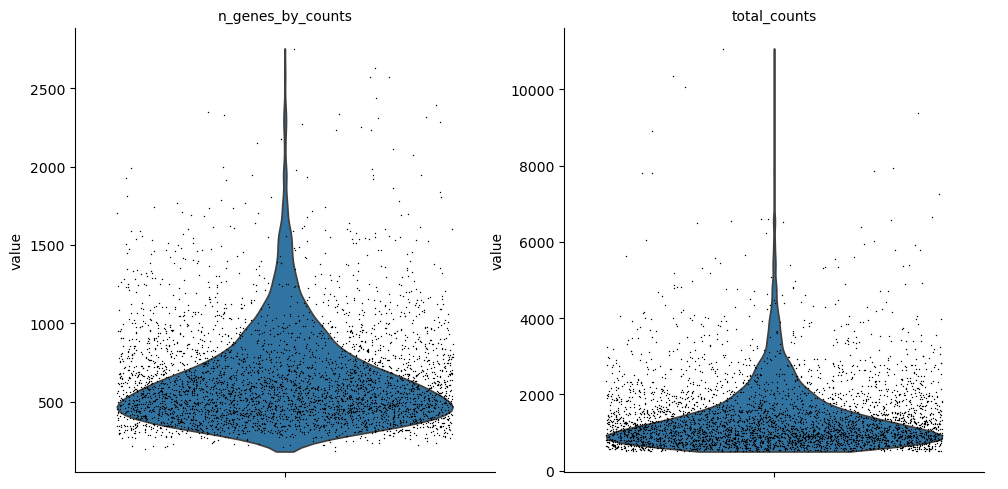

In [3]:
# Check some quality control metrics
# The first plot shows the number of unique genes found in each cell, the second shows the total counts in each cell

sc.pp.calculate_qc_metrics(he48, inplace=True)

sc.pl.violin(
    he48,
    ["n_genes_by_counts", "total_counts"],
    jitter=0.4,
    multi_panel=True,
)

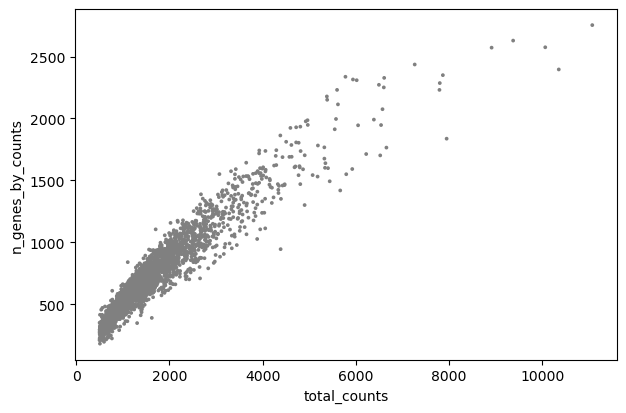

In [4]:
# Plot the relationship between the total number of counts in the cell and the number of unique genes in a cell

sc.pl.scatter(he48, "total_counts", "n_genes_by_counts")

In [5]:
# Remove cells that do not meet standard thresholds of gene numbers and counts per cell
sc.pp.filter_cells(he48, min_genes=200)
sc.pp.filter_cells(he48, max_counts=10000)
sc.pp.filter_cells(he48, max_genes=4000)

In [6]:
# Normalization and log-transformation
# This ensures that the data behaves much better in PCA and that outliers do not have too much of an effect on our analyses

he48.layers["counts"] = he48.X.copy()

sc.pp.normalize_total(he48)
sc.pp.log1p(he48)

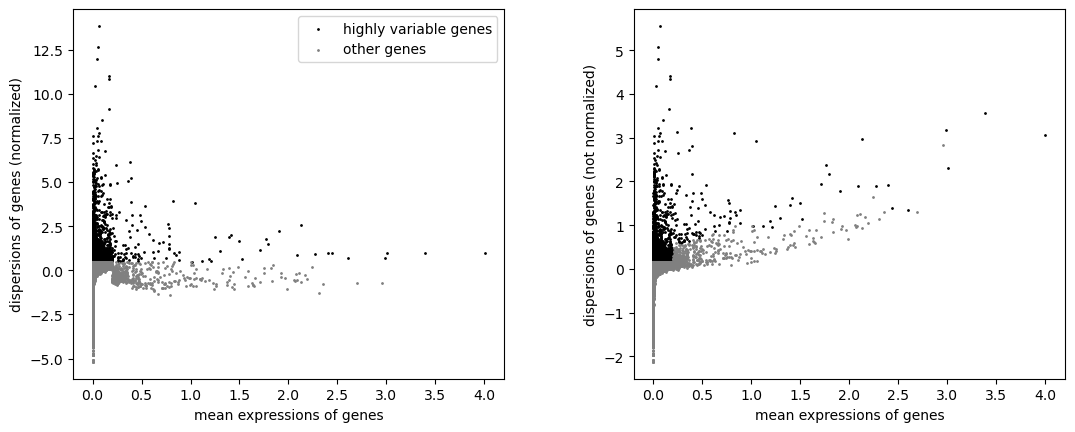

In [7]:
# Calculate the highly variable genes
# It is standard practice to retain only a few thousand of the most variable genes for downstream analyses
# as this simplifies the dimensionality we are dealing with (and we don't care if a gene is constant across all cells)

sc.pp.highly_variable_genes(he48, n_top_genes=4000, flavor="seurat")
sc.pl.highly_variable_genes(he48)

/Users/jordankalai/opt/anaconda3/envs/bio265/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:439: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


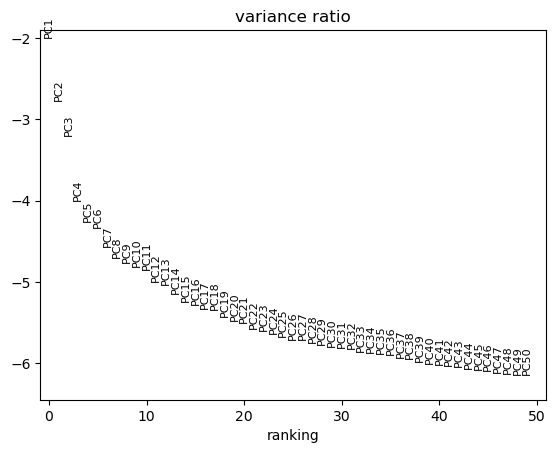

In [8]:
# Perform PCA, calculating the first 50 PCs
# The plot shows the amount of variance explain by each PC
# It looks like the first 50 PCs explain most of the variance

sc.pp.pca(he48, n_comps=50, use_highly_variable=True)
sc.pl.pca_variance_ratio(he48, n_pcs=50, log=True)

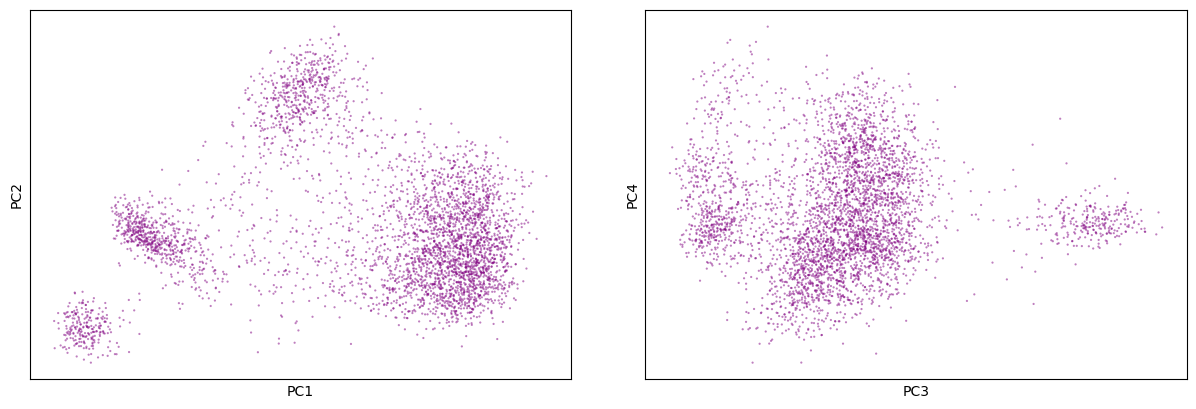

In [9]:
# Plot a few of the PCs against one another

sc.pl.pca(
    he48,
    dimensions=[(0, 1), (2, 3)],
    ncols=2,
    size=10,
    na_color = "purple",
    alpha = 0.5
)

In [10]:
# Calculate the neighbors of each cell, which is part of the UMAP method
sc.pp.neighbors(he48, n_neighbors=15, n_pcs=50, method="umap")

# Cluster the cells
# The leiden algorithm is the standard in the field, and performs better than regular k-means for single cell data
# I arbitrarily chose a resolution, which in this case gave us 16 clusters (instead of choosing a cluster number ahead of time)
# This is a pretty reasonable number for the number of celltypes you would see at this stage
sc.tl.leiden(he48, resolution=1.2, flavor="leidenalg")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/ly/r7njdrd56vd_c6s2mlks2kxh0000gn/T/ipykernel_6492/3891278091.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(he48, resolution=1.2, flavor="leidenalg")


In [11]:
# Perform the final UMAP analysis step
sc.tl.umap(he48)

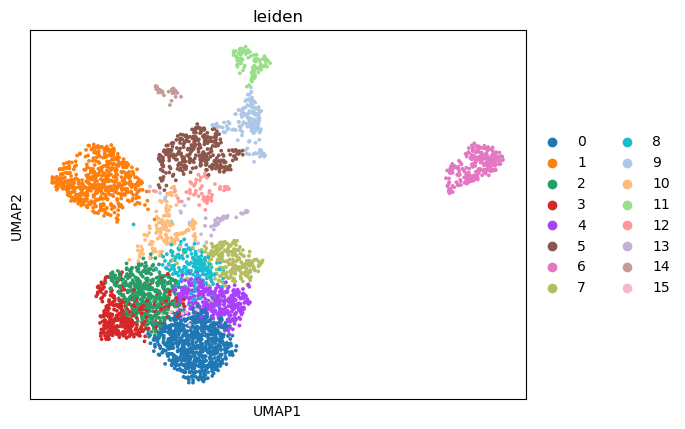

In [12]:
# Plot the first two UMAP dimensions
# Color cells by the cluster they belong to
sc.pl.umap(he48, color=["leiden"])

In [13]:
# Calculate the marker genes for each cell cluster
# Use the wilcoxon test, which performs well for single cell data
# Provide adjusted p-values using the benjamini-hochberg correction
sc.tl.rank_genes_groups(he48, "leiden", method="wilcoxon", corr_method='benjamini-hochberg')

In [14]:
# Store the marker genes in a table
# The number at the start of a column name indicates the cluster
# For each cluster, there are three columns -> the name of the gene, 
# the log2 fold change (how highly the gene is expressed in that cluster compared to others),
# and the adjusted p-value.
# The top 50 genes for each cluster are included, in order of their enrichment in that cluster (based on p-value).

result = he48.uns["rank_genes_groups"]
groups = result["names"].dtype.names
marker_genes = pd.DataFrame(
    {
        f"{group}_{key}": result[key][group]
        for group in groups
        for key in ["names", "logfoldchanges", "pvals_adj"]
    }
).head(50)

#marker_genes.to_csv("./he48_16clusters_marker_genes.csv", index = False)
marker_genes.head(15)

,0_names,0_logfoldchanges,0_pvals_adj,1_names,1_logfoldchanges,1_pvals_adj,2_names,2_logfoldchanges,2_pvals_adj,3_names,...,12_pvals_adj,13_names,13_logfoldchanges,13_pvals_adj,14_names,14_logfoldchanges,14_pvals_adj,15_names,15_logfoldchanges,15_pvals_adj
0,HER_16128.t1:none,2.793355,3.386194e-215,HER_45860.t1:Sp-Btub3,3.630664,2.252162e-258,HER_29018.t1:Sp-MacpfD.3,2.830693,1.981260e-132,HER_21799.t1:Sp-Cara14LA,...,1.006207e-25,HER_46925.t1:Sp-Mif4,4.976131,2.007983e-19,HER_42513.t1:Sp-Srcr177,6.886854,3.213070e-18,HER_37722.t1:Sp-Hypp_1457,5.829232,0.000036
1,HER_47969.t1:none,2.445162,5.827818e-195,HER_28.t1:Sp-FbsL_2,5.444964,3.250483e-234,HER_21799.t1:Sp-Cara14LA,1.839821,2.776467e-105,HER_29018.t1:Sp-MacpfD.3,...,5.086031e-14,HER_134.t1:Sp-Nxn_1,4.139631,2.007983e-19,HER_45847.t1:Sp-Astacin4,8.165260,2.099861e-17,HER_45847.t1:Sp-Astacin4,5.399904,0.000036
2,HER_7595.t1:Sp-Apob,2.133103,2.221538e-190,HER_29171.t1:none,5.762208,7.054382e-193,HER_29000.t1:Sp-MacpfD.3,2.201933,4.395454e-101,HER_8002.t1:Sp-Slsp_1,...,5.234468e-11,HER_7886.t1:Sp-Hypp_1597,4.280129,1.622567e-18,HER_37722.t1:Sp-Hypp_1457,7.282673,3.788744e-16,HER_42513.t1:Sp-Srcr177,5.080197,0.000036
3,HER_49824.t1:Sp-Ars,2.371336,3.208505e-156,HER_30721.t1:Sp-Cycs_2,1.400260,8.568588e-172,HER_3741.t1:Sp-Anxn,1.761420,7.094638e-88,HER_3741.t1:Sp-Anxn,...,2.906765e-08,HER_47882.t1:Sp-CalmL1,3.558728,1.182700e-16,HER_48026.t1:Sp-6Afcol,7.398757,3.107384e-15,HER_7595.t1:Sp-Apob,2.436376,0.005150
4,HER_9762.t1_HER_9764.t1:Sp-AnL4,2.225760,1.133831e-155,HER_19128.t2:Sp-CalmL1,1.959773,6.089110e-138,HER_23469.t1:Sp-Sdc,1.224416,2.307101e-72,HER_32297.t1:Sp-Ephrin,...,1.584453e-07,HER_4864.t1_HER_4874.t1:Sp-Agpat5,2.456703,7.280148e-16,HER_7690.t1:none,7.898321,3.055472e-14,HER_47882.t1:Sp-CalmL1,2.890850,0.007865
5,HER_17415.t1:Sp-Ckb,1.563637,9.168133e-114,HER_19127.t1:Sp-CalmL2,2.272007,1.190973e-133,HER_17967.t1:Sp-Map1a/1B_Lc3L2,1.155849,6.164198e-62,HER_23469.t1:Sp-Sdc,...,4.178224e-07,HER_46284.t1:Sp-Cara2LB_1,3.304439,2.027989e-15,HER_40156.t1:Sp-185/333D1,7.572637,4.580318e-14,HER_134.t1:Sp-Nxn_1,2.653261,0.010432
6,HER_10974.t1:Sp-Hbn,3.400166,7.858190e-100,HER_24381.t1:Sp-HH2az,1.288267,2.067504e-131,HER_20104.t1:Sp-Tppp3,1.433857,1.140993e-53,HER_49824.t1:Sp-Ars,...,4.949130e-06,HER_21637.t1:Sp-Aldh2,2.571035,2.027989e-15,HER_47882.t1:Sp-CalmL1,4.095412,4.917438e-14,HER_9898.t1:Sp-Bhmt_1,3.625402,0.010569
7,HER_7898.t1:Sp-Pdcd4,1.224566,6.068483e-98,HER_35876.t1:Sp-Atub13,1.775120,6.859816e-118,HER_20850.t1:Sp-Egfi,1.844506,7.901755e-50,HER_40059.t1:Sp-Hox7,...,6.911982e-06,HER_12207.t1:Sp-Nme1,3.443765,4.193938e-15,HER_34053.t1_HER_34055.t1:none,4.113299,1.575630e-10,HER_34053.t1_HER_34055.t1:none,2.897691,0.013679
8,HER_23469.t1:Sp-Sdc,1.189049,1.787122e-91,HER_45861.t1:Sp-Btub3,1.838811,1.240037e-109,HER_5235.t1:Sp-Otof,1.207566,1.864327e-45,HER_23964.t1:Sp-Gsn,...,1.170143e-05,HER_47602.t1:Sp-Fmo2_2,3.697728,4.728602e-15,HER_6994.t1:Sp-TxnL3,2.517891,2.412633e-10,HER_40156.t1:Sp-185/333D1,4.885100,0.022186
9,HER_17866.t1:Sp-Six3,2.632477,6.600019e-91,HER_35862.t1:Sp-Atub13,1.954564,1.029641e-102,HER_49824.t1:Sp-Ars,1.676819,3.979065e-39,HER_29000.t1:Sp-MacpfD.3,...,6.578620e-05,HER_19785.t1:none,2.761846,5.363475e-15,HER_45489.t1:Sp-Cycpln,5.920933,9.173850e-10,HER_7690.t1:none,5.267035,0.109620


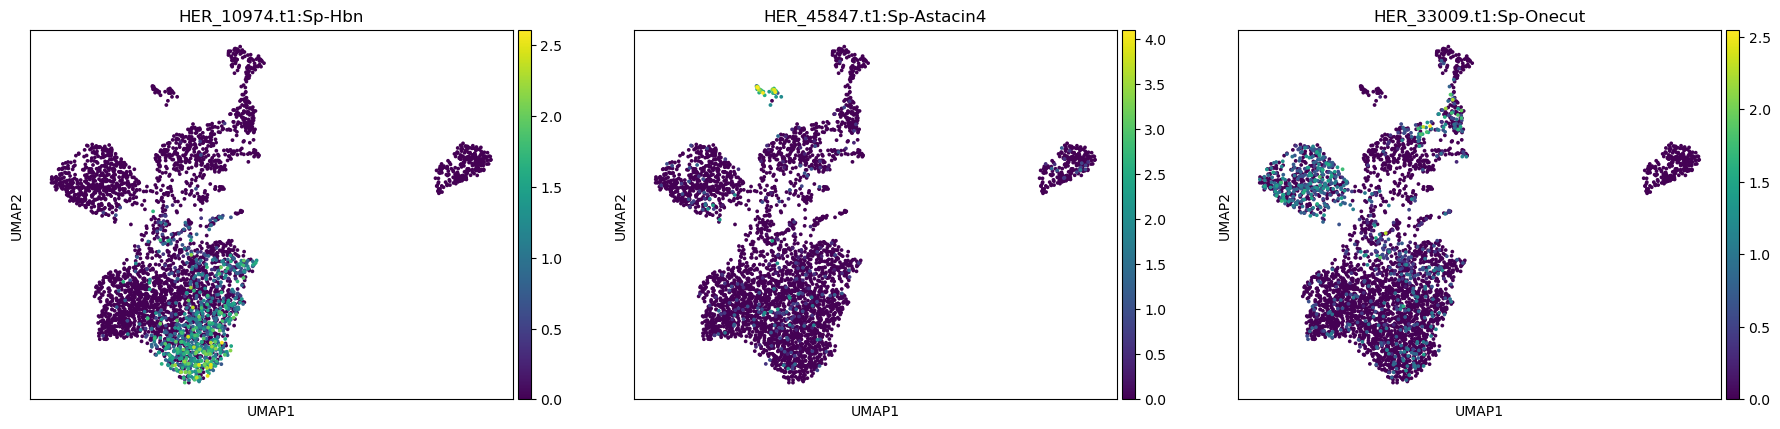

In [15]:
# Plot the expression patterns of a few marker genes
# Hbn marks the animal pole domain (neural ectoderm)
# Astacin4 marks the blastocoelar cells
# Onecut marks the ciliary band

sc.pl.umap(he48, color=["HER_10974.t1:Sp-Hbn", "HER_45847.t1:Sp-Astacin4", "HER_33009.t1:Sp-Onecut"])

In [16]:
# Save the processed data
he48.write_h5ad("./he48_processed.h5ad")

In [4]:
he48 = ad.read_h5ad("./he48_processed.h5ad")

In [5]:
he48

AnnData object with n_obs × n_vars = 4080 × 38707
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'n_counts', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'